In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
# df_trace = pd.read_csv('tmp_23000.csv', engine='python')
df_trace = pd.read_csv('tmp_40000.csv', engine='python')


#df_trace = pd.read_csv('thread_trace_s2_23000.csv', engine='python')


In [3]:
# my_stream_list = []

# for index, row in df_trace.iterrows():
#     current_stream = row['stream_id']
    
#     if current_stream not in my_stream_list:
#         #print index
#         my_stream_list.append(current_stream)
        
# print my_stream_list 

### determine the number of streams

In [4]:
stream_unique = df_trace['stream_id'].unique()

In [5]:
totalSM = df_trace['sm_id'].unique()

In [6]:
stream_info_dd = {}

In [7]:
def SM_blkinfo(df_current_stream):
    blocks_unique = df_current_stream['block_id'].unique()
    num_blocks = len(blocks_unique)

    # get block timing and sm info
    df_trace_new = pd.DataFrame(columns=['sm_id', 
                                         'block_id', 
                                         'block_start', 
                                         'block_end'])


    for i in blocks_unique:
        df_block = df_current_stream.loc[df_current_stream['block_id'] == i]
        min_ = min(df_block['start'])
        max_ = max(df_block['end'])

        reside_sm = df_block['sm_id'].iloc[0]

        df_trace_new = df_trace_new.append(
            {'sm_id': reside_sm,
            'block_id': i,
            'block_start': min_,
            'block_end': max_}, ignore_index=True)
        
    
    sm_info_dd = {}

    sm_unique = df_trace_new['sm_id'].unique()

    for i in sm_unique:
        df_current = df_trace_new.loc[df_trace_new['sm_id'] == i]
        sm_info_dd[i] = df_current
        
    
    return sm_info_dd

In [8]:
# get stream data
stream_info_dd = {}

for stream_id in stream_unique:
    df_current_stream = df_trace.loc[df_trace['stream_id'] == stream_id]
    sm_info_dd = SM_blkinfo(df_current_stream) # block trace for each SM
    stream_info_dd[stream_id] = sm_info_dd # SM trace for each stream

### plot data for all streams on each SM

In [9]:
def run_plot(df_s1, df_s2):
    import matplotlib.pyplot as plt
    
    df_s1['y_axis'] = pd.Series(np.arange(1,len(df_s1.index)+1), 
                                 index=df_s1.index)
    
    df_s2['y_axis'] = pd.Series(np.arange(1,len(df_s2.index)+1) + 0.1, 
                                 index=df_s2.index)
                                     
    x0=df_s1['block_start']
    x1=df_s1['block_end']
    y0=df_s1['y_axis']
                                
    x0_=df_s2['block_start']
    x1_=df_s2['block_end']
    y0_=df_s2['y_axis']

    ylim_max = max(df_s1['y_axis']) + 1
    axes = plt.gca()
    axes.set_ylim([0, ylim_max])

    plt.hlines(y0,x0,x1, lw=2, color='r')
    plt.hlines(y0_,x0_,x1_, lw=2, color='k')
                                
#     plt.title('Memory Bound')
    plt.xlabel('Time(clocks)')
    plt.ylabel('Blocks')
    plt.show()

    

overlapping on SM 0
ovlp ratio : 0.235589206927
sm timing : 3946.282631 - 3946.515796


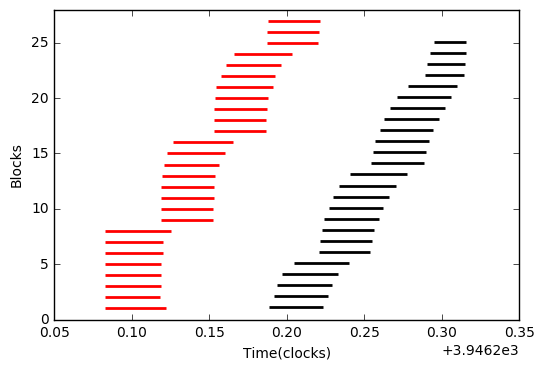

overlapping on SM 1
ovlp ratio : 0.220528282969
sm timing : 1498.755418 - 1498.989437


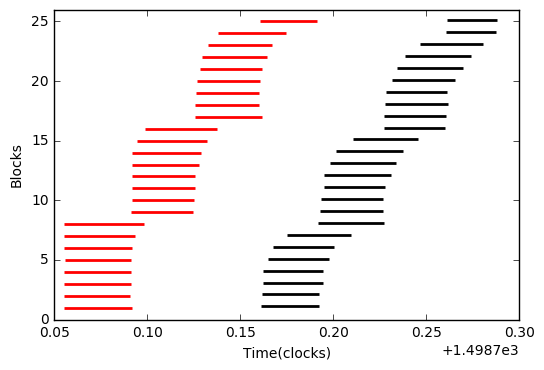

overlapping on SM 2
ovlp ratio : 0.234624227876
sm timing : 3946.282635 - 3946.515878


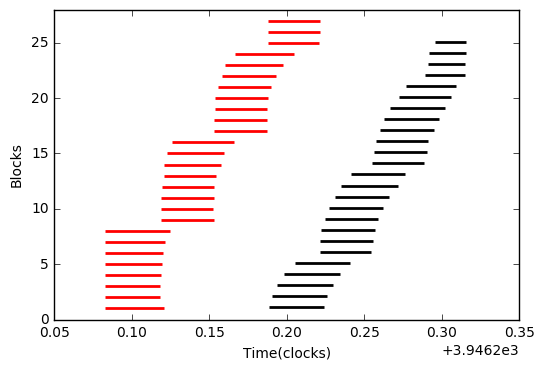

overlapping on SM 3
ovlp ratio : 0.231553179435
sm timing : 1498.755422 - 1498.98845


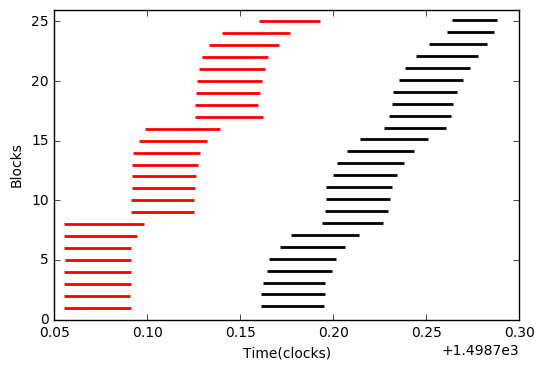

overlapping on SM 4
ovlp ratio : 0.234720215117
sm timing : 3946.282631 - 3946.516104


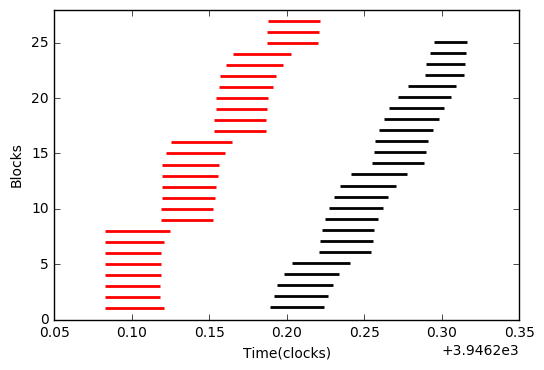

overlapping on SM 5
ovlp ratio : 0.237500720419
sm timing : 1498.755418 - 1498.988359


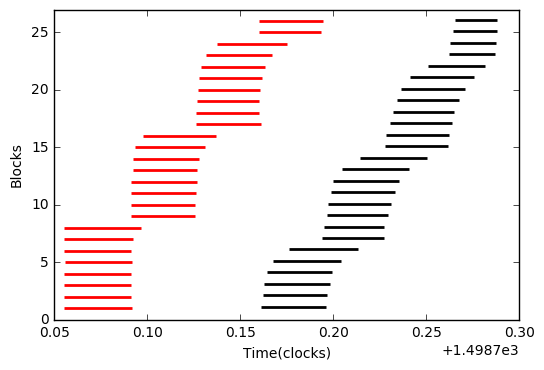

In [10]:
#check whether there is concurrency on each SM for each stream
total_stream_num = len(stream_unique)

for sm in totalSM:
    for stream in stream_unique:
        # compare the stream next
        if stream + 1 < total_stream_num:
            continue_plot = 0
            
            # check the stream timing on current SM
            df_s1 = stream_info_dd[stream][sm]
            df_s2 = stream_info_dd[stream+1][sm]
            
            #print df_s1
            #print df_s2
            
            s1_start = min(df_s1['block_start'])
            s1_end = max(df_s1['block_end'])
            
            s2_start = min(df_s2['block_start'])
            s2_end = max(df_s2['block_end'])
            
            if s1_start <= s2_start <= s1_end:
                print "overlapping on SM " + str(sm)
                print  "ovlp ratio : " + str((s1_end  - s2_start) / (s1_end - s1_start))
                
                print "sm timing : " + str(s1_start) + " - " + str(s2_end)
                
                continue_plot = 1
            else:
                print "no overlapping on SM " + str(sm)
            
            if continue_plot:
                run_plot(df_s1, df_s2)
        